# Gaussian process kernels

In [1]:
%matplotlib inline

import sys
import numpy as np
from numpy import exp, sin, pi, abs
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm # Colormaps
import matplotlib.gridspec as gridspec
import seaborn as sns

sns.set_style('darkgrid')
np.random.seed(42)
EPS = 1e-10  # Thikonov regularisation term
# Print versions used
print('Python: {}.{}.{}'.format(*sys.version_info[:3]))
print('numpy: {}'.format(np.__version__))
print('scipy: {}'.format(scipy.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('seaborn: {}'.format(sns.__version__))
#

Python: 3.6.6
numpy: 1.15.1
scipy: 1.1.0
matplotlib: 2.2.3
seaborn: 0.9.0


## Kernel function

The [covariance](https://en.wikipedia.org/wiki/Covariance_function) can be modelled by a [kernel](https://en.wikipedia.org/wiki/Positive-definite_kernel) function $K(X,Y)$ that models how much the samples from $X$ and $Y$ change together. $K(X,Y)$ is positive if there is some similarity between the samples and will be zero if the samples are completely independent.

### Radial basis function kernel
A popular kernel is the [radial basis function](https://en.wikipedia.org/wiki/Radial_basis_function_kernel) (RBF) kernel: 

$$K(X,X') = \exp \left( -\frac{1}{2\sigma^2} \lVert X-X' \rVert^2 \right) $$

TODO: Multidimensional?

This kernel is illustrated in the next figure which shows the distance with respect to $0$: $K(0,y)$. Note that the similarity outputted by the kernel decreases exponentially towards $0$ the farther we move move away from the center, and that the similarity is maximum at the center $\mathbf{x}=\mathbf{y}$. Also note that the parameter $\sigma$ (width) defines how fast the similarity decreases. This means that the output of the RBF kernel function $K(\mathbf{x},\mathbf{y})$ is a similarity based on how close $\mathbf{x}$ lies to $\mathbf{y}$, the greater $\sigma$ is, the greater this distance effect.

### Prior
The specification of this covariance function implies a distribution over functions $f(X)$. By choosing a specific kernel function $K$ it possible to set some [prior](https://en.wikipedia.org/wiki/Prior_probability) information on this distribution. For example the RBF kernel captures the prior information that the data lies in a [smooth](https://en.wikipedia.org/wiki/Smoothness) space. This is because it is infinitely differentiable over its full range. I will illustrate this more later in this tutorial.

### Valid kernels
In order to be a valid kernel function the resulting kernel matrix should be [positive definite](https://en.wikipedia.org/wiki/Positive-definite_matrix). Which means that the matrix should be [symmetric](https://en.wikipedia.org/wiki/Symmetric_matrix) since $K(\mathbf{x},\mathbf{y}) = K(\mathbf{y},\mathbf{x})$, and that the output of the kernel function should be positive ($K(\mathbf{x},\mathbf{y}) \geq 0$). Being positive definite also means that the kernel matrix is [invertable](https://en.wikipedia.org/wiki/Invertible_matrix).

In [2]:
# Define the RBF kernel
def rbf_kernel(xa, xb, scale=1):
    """Radial Basis Function (RBF) kernel"""
    # L2 distance (Squared Euclidian)
    sq_norm = scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return exp(-scale * sq_norm)

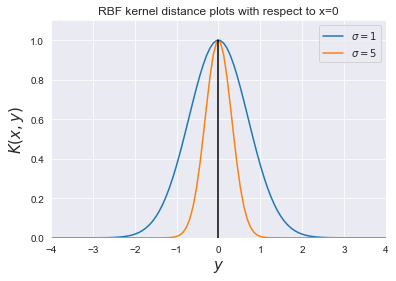

In [3]:
# Plot some kernel values of y with respect to 0
X = np.expand_dims(np.linspace(-4, 4, num=100), 1)
zero = np.array([[0]])
y1 = rbf_kernel(zero, X, 1)
y2 = rbf_kernel(zero, X, 5)
# Make the plots
plt.plot(X[:,0], y1[0,:], label='$\sigma=1$')
plt.plot(X[:,0], y2[0,:], label='$\sigma=5$')
plt.plot((0, 0), (0, 1), 'k-')
plt.xlabel('$y$', fontsize=15)
plt.ylabel('$K(x,y)$', fontsize=15)
plt.title('RBF kernel distance plots with respect to x=0')
plt.ylim([0, 1.1])
plt.xlim([-4, 4])
plt.legend(loc=1)
plt.show()
#

### RBF kernel as smooth prior

Note that the identity matrix $I$ contains ones on the diagonal and zeros everywhere else. This means that all samples taken from $\mathcal{N}(0,I)$ are independent of eachother and we can just sample each sample seperately. These independent samples are then transformed with the help of the linear transformation $L$ that maps the independent samples to a space where they are more correlated. This correlation is defined by the kernel matrix $K=LL^\top$.  
The next figures illustrate how increasing the width $\sigma$ of the kernel increases it smoothnes.

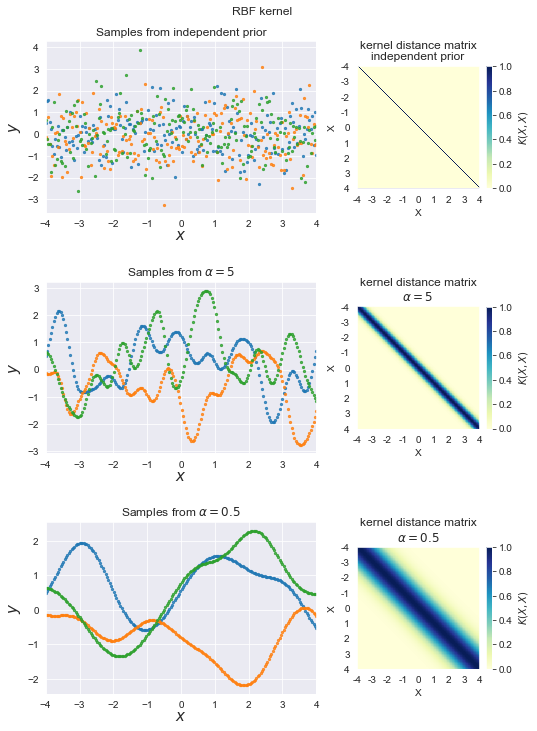

In [4]:
def plot_kernel(X, y, K, description, subplot_spec, xlim):
    grid_spec = gridspec.GridSpecFromSubplotSpec(
        1, 2, width_ratios=[2,1], height_ratios=[1],
        subplot_spec=subplot_spec)
    ax1 = plt.subplot(grid_spec[0])
    ax2 = plt.subplot(grid_spec[1])
    # Plot samples
    for i in range(y.shape[1]):
        ax1.scatter(X, y[:,i], alpha=0.8, s=5)
    ax1.set_ylabel('$y$', fontsize=15)
    ax1.set_xlabel('$x$', fontsize=15, labelpad=0)
    ax1.set_xlim(xlim)
    ax1.set_title(f'Samples from {description}')
    # Plot covariance matrix
    im = ax2.imshow(K, cmap=cm.YlGnBu)
    cbar = plt.colorbar(im, ax=ax2, fraction=0.045, pad=0.05)
    cbar.ax.set_ylabel('$K(X,X)$', fontsize=10)
    ax2.set_title(f'kernel distance matrix\n{description}')
    ax2.set_xlabel('X')
    ax2.set_ylabel('X')
    ticks = list(range(xlim[0], xlim[1]+1))
    ax2.set_xticks(np.linspace(0, len(X), len(ticks)))
    ax2.set_yticks(np.linspace(0, len(X), len(ticks)))
    ax2.set_xticklabels(ticks)
    ax2.set_yticklabels(ticks)

    ax2.grid(False)
    


# Show samples from GPs defined by a different RBF kernels
nb_of_samples = 200  # Number of test points.
nb_of_realizations = 3  # Number of function realizations
# Generate independent samples that can be transformed
xlim = (-4, 4)
X = np.expand_dims(np.linspace(*xlim, nb_of_samples), 1)
y_independent = np.random.normal(
    size=(nb_of_samples, nb_of_realizations))

# Start plotting
fig = plt.figure(figsize=(8, 12)) 
gs = gridspec.GridSpec(3, 1)
# Adjust spacing between subplots
gs.update(wspace=0.0, hspace=0.4)

# Sample from the prior
K_1 = np.eye(nb_of_samples)
L_1 = np.linalg.cholesky(K_1 + EPS * np.eye(nb_of_samples))
y_1 = L_1.dot(y_independent)
# Plot
plot_kernel(X, y_1, K_1, 
            'independent prior', gs[0], xlim)

# Sample from the prior
K_2 = rbf_kernel(X, X, scale=5) # Kernel at test points.
L_2 = np.linalg.cholesky(K_2 + EPS * np.eye(nb_of_samples))
y_2 = L_2.dot(y_independent)
# Plot
plot_kernel(X, y_2, K_2, '$\\alpha=5$', gs[1], xlim)

# Sample from the prior
K_3 = rbf_kernel(X, X, scale=0.5) # Kernel at test points.
L_3 = np.linalg.cholesky(K_3 + EPS * np.eye(nb_of_samples))
y_3 = L_3.dot(y_independent)
# Plot
plot_kernel(X, y_3, K_3, '$\\alpha=0.5$', gs[2], xlim)
plt.suptitle('RBF kernel', y=0.92)
plt.show()
#

## Periodic

$$
K(X,X') = \exp \left(-\frac{2}{l^2} \sin^2 \left( \pi \frac{ \lvert X-X' \rvert}{p} \right) \right)
$$

In [5]:
# Define the periodic kernel
def periodic_kernel(xa, xb, l=1, p=1):
    """Periodic kernel"""
    # L1 distance (Manhattan or cityblock)
    diff = scipy.spatial.distance.cdist(xa, xb, 'cityblock')
    return exp(-(2 / (l**2)) * sin(pi*diff/p)**2)

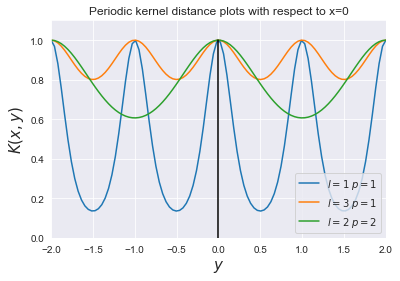

In [6]:
# Plot some kernel values of y with respect to 0
x = np.linspace(-2, 2, num=100)
zero = np.array([[0]])
y1 = [periodic_kernel(
    zero, np.array([[xi]]), l=1, p=1)[0,0] for xi in x]
y2 = [periodic_kernel(
    zero, np.array([[xi]]), l=3, p=1)[0,0] for xi in x]
y3 = [periodic_kernel(
    zero, np.array([[xi]]), l=2, p=2)[0,0] for xi in x]
# Make the plots
plt.plot(x, y1, label='$l=1 \; p=1$')
plt.plot(x, y2, label='$l=3 \; p=1$')
plt.plot(x, y3, label='$l=2 \; p=2$')
plt.plot((0, 0), (0, 1), 'k-')
plt.xlabel('$y$', fontsize=15)
plt.ylabel('$K(x,y)$', fontsize=15)
plt.title('Periodic kernel distance plots with respect to x=0')
plt.ylim([0, 1.1])
plt.xlim([-2, 2])
plt.legend(loc=4)
plt.show()
#

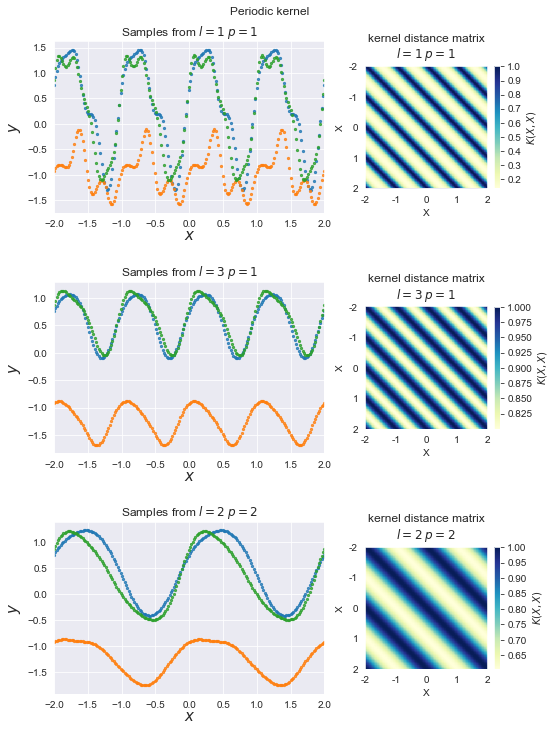

In [7]:
# Show samples from GPs defined by different preriodic kernels
nb_of_samples = 200  # Number of test points.
nb_of_realizations = 3  # Number of function realizations
# Generate independent samples that can be transformed
xlim = (-2, 2)
X = np.expand_dims(np.linspace(*xlim, nb_of_samples), 1)
y_independent = np.random.normal(
    size=(nb_of_samples, nb_of_realizations))

# Start plotting
fig = plt.figure(figsize=(8, 12)) 
gs = gridspec.GridSpec(3, 1)
# Adjust spacing between subplots
gs.update(wspace=0.0, hspace=0.4)

# Sample from the prior
K_1 = periodic_kernel(X, X, l=1, p=1) # Kernel at test points.
L_1 = np.linalg.cholesky(K_1 + EPS * np.eye(nb_of_samples))
y_1 = L_1.dot(y_independent)
# Plot
plot_kernel(X, y_1, K_1, '$l=1 \; p=1$', gs[0], xlim)

# Sample from the prior
K_2 = periodic_kernel(X, X, l=3, p=1)  # Kernel at test points.
L_2 = np.linalg.cholesky(K_2 + EPS * np.eye(nb_of_samples))
y_2 = L_2.dot(y_independent)
# Plot
plot_kernel(X, y_2, K_2, '$l=3 \; p=1$', gs[1], xlim)

# Sample from the prior
K_3 = periodic_kernel(X, X, l=2, p=2)  # Kernel at test points.
L_3 = np.linalg.cholesky(K_3 + EPS * np.eye(nb_of_samples))
y_3 = L_3.dot(y_independent)
# Plot
plot_kernel(X, y_3, K_3, '$l=2 \; p=2$', gs[2], xlim)
plt.suptitle('Periodic kernel', y=0.92)
plt.show()
#

## Linear kernel

In [17]:
# Define the periodic kernel
def linear_kernel(xa, xb, b=0, c=0, l=1):
    """Linear kernel"""
    return l**2 * (b**2 + ((xa-c) @ (xb.T-c)))

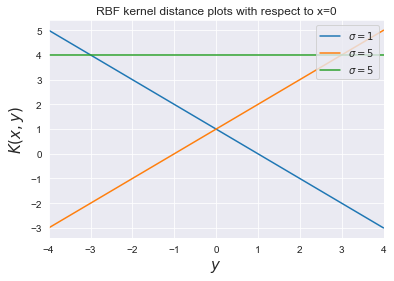

In [18]:
# Plot some kernel values of y with respect to 0
X = np.expand_dims(np.linspace(-4, 4, num=100), 1)
zero = np.array([[0]])
y1 = linear_kernel(zero, X, b=0, c=1)
y2 = linear_kernel(zero, X, b=0, c=-1)
y3 = linear_kernel(zero, X, b=2, c=0)
# Make the plots
plt.plot(X[:,0], y1[0,:], label='$\sigma=1$')
plt.plot(X[:,0], y2[0,:], label='$\sigma=5$')
plt.plot(X[:,0], y3[0,:], label='$\sigma=5$')
# plt.plot((0, 0), (0, 1), 'k-')
plt.xlabel('$y$', fontsize=15)
plt.ylabel('$K(x,y)$', fontsize=15)
plt.title('RBF kernel distance plots with respect to x=0')
# plt.ylim([0, 1.1])
plt.xlim([-4, 4])
plt.legend(loc=1)
plt.show()
#

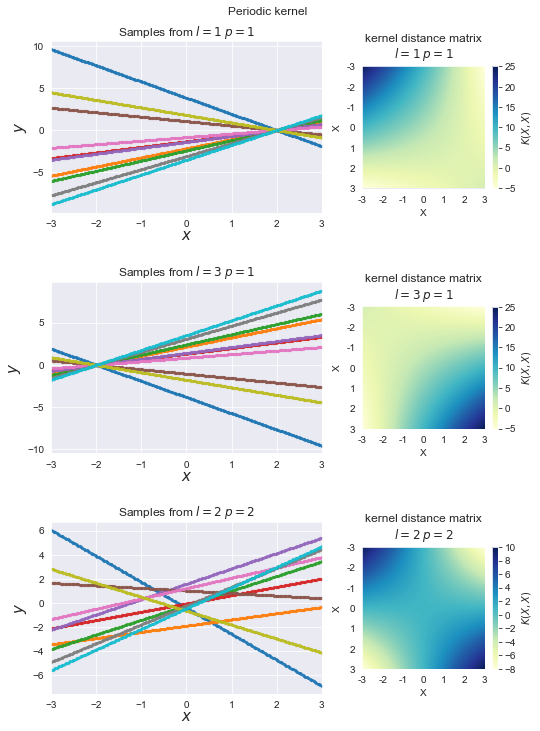

In [22]:
# Show samples from GPs defined by different preriodic kernels
nb_of_samples = 200  # Number of test points.
nb_of_realizations = 10 # Number of function realizations
# Generate independent samples that can be transformed
xlim = (-3, 3)
X = np.expand_dims(np.linspace(*xlim, nb_of_samples), 1)
y_independent = np.random.normal(
    size=(nb_of_samples, nb_of_realizations))

# Start plotting
fig = plt.figure(figsize=(8, 12)) 
gs = gridspec.GridSpec(3, 1)
# Adjust spacing between subplots
gs.update(wspace=0.0, hspace=0.4)

# Sample from the prior
K_1 = linear_kernel(X, X, b=0, c=2) # Kernel at test points.
L_1 = np.linalg.cholesky(K_1 + EPS * np.eye(nb_of_samples))
y_1 = L_1.dot(y_independent)
# Plot
plot_kernel(X, y_1, K_1, '$l=1 \; p=1$', gs[0], xlim)

# Sample from the prior
K_2 = linear_kernel(X, X, b=0, c=-2)  # Kernel at test points.
L_2 = np.linalg.cholesky(K_2 + EPS * np.eye(nb_of_samples))
y_2 = L_2.dot(y_independent)
# Plot
plot_kernel(X, y_2, K_2, '$l=3 \; p=1$', gs[1], xlim)

# Sample from the prior
K_3 = linear_kernel(X, X, b=1, c=0, l=1)  # Kernel at test points.
L_3 = np.linalg.cholesky(K_3 + EPS * np.eye(nb_of_samples))
y_3 = L_3.dot(y_independent)
# Plot
plot_kernel(X, y_3, K_3, '$l=2 \; p=2$', gs[2], xlim)
plt.suptitle('Periodic kernel', y=0.92)
plt.show()
#

- https://www.cs.toronto.edu/~duvenaud/cookbook/
- http://www.gaussianprocess.org/gpml/chapters/RW4.pdf
- file:///home/peter/Downloads/holiday/kernels.pdf
- https://mlkernels.readthedocs.io/en/latest/kernels.html
- http://ml.dcs.shef.ac.uk/gpss/gpws14/KernelDesign.pdf